# Final project

In [2]:
import sqlite3 as sql
import pandas as pd
import plotly.express as px
import numpy as np
from scipy.stats import zscore
import plotly.io as pio
from tensorflow import keras
from tensorflow.keras import layers, models
from keras import regularizers
import seaborn as sns
import tensorflow as tf
from tensorflow import math as tfmath
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from plotly.offline import plot, iplot, init_notebook_mode
pio.renderers.default = "notebook_connected+colab"
init_notebook_mode(connected=True)

# Part 1
### Graph the number of accidents across time
##### Get the data using sqlite3 module

In [19]:
# get the data with sqlite
# remove entries from 2021 because there is a lot of missing data from that year
con = sql.connect("switrs.sqlite")
cur = con.cursor()

query1 = """SELECT strftime('%Y-%m',collision_date) AS date, strftime('%Y', collision_date) as year, 
COUNT(collision_date) as count 
FROM collisions 
WHERE strftime('%Y', collision_date) != '2021' 
GROUP BY date 
ORDER BY date"""

data = pd.read_sql(query1, con)

##### Create the plot using plotly

In [20]:
pio.renderers.default = 'plotly_mimetype'

fig = px.line(data, x="date", y ="count", title="Accidents in California from 2001 to 2020",
              labels={
                  "date":"month and year of accident",
                  "count":"accident frequency"
              })
fig.update_layout(xaxis=dict(tickmode="array", tickvals=data['date'][::12], ticktext=data['year'][::12]))
fig.update_traces(hovertemplate="%{x|%b %Y}")
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
                      dict(count=6, step="month", label="6 months", stepmode="backward"),
                      dict(count=1, step="year", label="1 year", stepmode="backward"),
                      dict(count=5, step="year", label="5 years", stepmode="backward"),
                      dict(step="all")
                      
                      ])
    )
)
fig.show()

### Graph the frequency of collision severity
##### Get the data using sqlite

In [21]:
query2 = """
SELECT strftime('%Y', collision_date) as year, collision_severity, 
COUNT(collision_severity) as severity_count 
FROM collisions 
WHERE strftime('%Y',collision_date) != '2021' 
AND collision_severity != 'N' 
GROUP BY year, collision_severity
"""

data2 = pd.read_sql(query2,con)
pd.options.display.max_rows=10


##### Create the histogram using plotly

In [22]:

pio.renderers.default = 'plotly_mimetype'

fig2 = px.histogram(data2, x='year', y='severity_count', barmode="group",
              color='collision_severity', 
              title="Severity of accidents from 2001 to 2020",
              labels= {
                  'year': 'Year',
                  'severity_count': 'Frequency',
                  'collision_severity': 'Collision Severity'
              })
fig2.show()

# Part 2
### Build neural network that predicts accident severity

The next part of this assignment will be about building a neural network which can predict collision severity type.

Included features:
- collision_time: Time crash occured (only used hour of day, processed as numerical)
- year: Year accident took place (categorical)
-month: Month the accident took place (categorical)
- chp_beat_type: Location of crash (categorical)
- distance: Distance of the crash from the intersection with secondary road (numerical)
- direction: Direction of the crash from the intersection with the secondary roadway (categorical)
- weather1: Weather condition at the time of the crash (categorical)
- party_count: Number of vehicles involved in crash (numerical)
- primary_coll_factor: Primary collision factor (categorical)
- type_of_collision: The general type of crash (categorical)
- motor_vehicle_involved_with: Describes what, in conjunction with a motor vehicle in-transport, produced the first injury or damage-causing event, on or off the road (categorical)
- road_surface: Roadway surface condition at the time of the crash (categorical)
- road_cond_1: Roadway condition at the time of the crash (categorical)
- lighting: Lighting conditions at the crash location and the time of the crash (categorical)
- bicycle_accident: Indicates whether the crash involved a bicycle (binary)
- motorcycle_accident: Indicates whether the crash involved a motorcycle (binary)
- truck_accident: 	Indicates whether the crash involved a big truck (binary)

##### Get the data using sqlite


In [23]:
# select all columns, randomly orden the data and select 10,000 data points
queryNN = """
SELECT collision_severity,
collision_time,
strftime('%Y', collision_date) as year,
strftime('%m', collision_date)as month,
chp_beat_type,
distance,
weather_1,
party_count,
primary_collision_factor,
type_of_collision,
motor_vehicle_involved_with,
road_surface,
road_condition_1,
lighting,
bicycle_collision,
motorcycle_collision,
truck_collision
FROM collisions
ORDER BY RANDOM()
LIMIT 10000
"""

dataNN = pd.read_sql(queryNN,con)
display(dataNN)

,collision_severity,collision_time,year,month,chp_beat_type,distance,weather_1,party_count,primary_collision_factor,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,bicycle_collision,motorcycle_collision,truck_collision
0,property damage only,07:50:00,2003,03,safety services program,0.0,clear,2,vehicle code violation,broadside,other motor vehicle,dry,normal,daylight,0,0,0
1,pain,13:39:00,2019,07,not chp,507.0,clear,2,vehicle code violation,broadside,other motor vehicle,dry,normal,daylight,0,0,0
2,property damage only,18:10:00,2018,12,interstate,525.0,clear,2,vehicle code violation,hit object,fixed object,dry,normal,dark with no street lights,0,0,0
3,property damage only,21:00:00,2004,08,not chp,77.0,clear,2,vehicle code violation,broadside,parked motor vehicle,dry,normal,dark with street lights,0,0,0
4,property damage only,11:20:00,2016,12,not chp,150.0,clear,2,vehicle code violation,sideswipe,other motor vehicle,dry,normal,daylight,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,property damage only,23:36:00,2015,04,not chp,0.0,clear,1,vehicle code violation,hit object,fixed object,dry,normal,dark with street lights,0,0,0
9996,property damage only,08:03:00,2014,11,interstate,50.0,clear,3,vehicle code violation,rear end,other motor vehicle,dry,normal,daylight,0,0,0
9997,pain,16:35:00,2013,03,not chp,0.0,clear,3,vehicle code violation,rear end,other motor vehicle,dry,normal,daylight,0,0,0
9998,property damage only,21:45:00,2002,06,county road area,7392.0,clear,1,vehicle code violation,hit object,fixed object,dry,normal,dark with no street lights,0,0,0


##### Get the hour of the day and transform to float

In [24]:
# get hour of day from the time column
dataNN["collision_time"] = dataNN["collision_time"].str.split(":").str[0].astype(float)

##### One hot encode categorical variables

In [25]:
# one hot encode variables
data_rows_encode = ["year","month","chp_beat_type", "weather_1","primary_collision_factor", 
               "type_of_collision", "motor_vehicle_involved_with", "road_surface",
               "road_condition_1","lighting"]


data_dummies = pd.get_dummies(dataNN[data_rows_encode])
label_dummies = pd.get_dummies(dataNN["collision_severity"])

#display(data_dummies)
#display(label_dummies)


##### Create df with data to use and transform into matrix

In [26]:
# drop rows that were one hot encoded and the labels and merge df with dummie variables
final_data = dataNN.drop(data_rows_encode + ["collision_severity"],axis=1).merge(data_dummies,left_index=True, right_index=True)

# fill na's for collision time with the mean
final_data["collision_time"] = final_data["collision_time"].fillna(value=np.mean(final_data["collision_time"]))

# normalize the numeric variables (collision_time, distance, party_count)
numerical = ["collision_time", "distance", "party_count"]
final_data[numerical] = final_data[numerical].apply(zscore)

# transform df to array
data_array_NN = final_data.to_numpy()
labels_array_NN = label_dummies.to_numpy()
print(labels_array_NN.shape)
print(data_array_NN.shape)

(10000, 5)
(10000, 95)


##### Build neural network

In [27]:
# get testing and training set
from sklearn.model_selection import train_test_split

data_array_NN = np.array(data_array_NN).astype(np.float32)
labels_array_NN = np.array(labels_array_NN).astype(np.float32)
X_train, X_test, y_train, y_test = train_test_split(data_array_NN, labels_array_NN, train_size=0.7)


c:\Users\miade\miniconda3\envs\SP\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.3553 - loss: 6.2589 - val_accuracy: 0.6057 - val_loss: 5.2844
Epoch 2/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5662 - loss: 5.2188 - val_accuracy: 0.6057 - val_loss: 4.7094
Epoch 3/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6001 - loss: 4.6069 - val_accuracy: 0.6043 - val_loss: 4.2630
Epoch 4/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6258 - loss: 4.1095 - val_accuracy: 0.6100 - val_loss: 3.8279
Epoch 5/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6332 - loss: 3.6710 - val_accuracy: 0.6200 - val_loss: 3.4517
Epoch 6/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6279 - loss: 3.3082 - val_accuracy: 0.6400 - val_loss: 3.1016
Epoch 7/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6383 - loss: 2.9626 - val_accuracy: 0.6343 - val_loss: 2.7940
Epoch 8/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6245 - loss: 2.6751 - val_accuracy: 0.6300 - val_loss

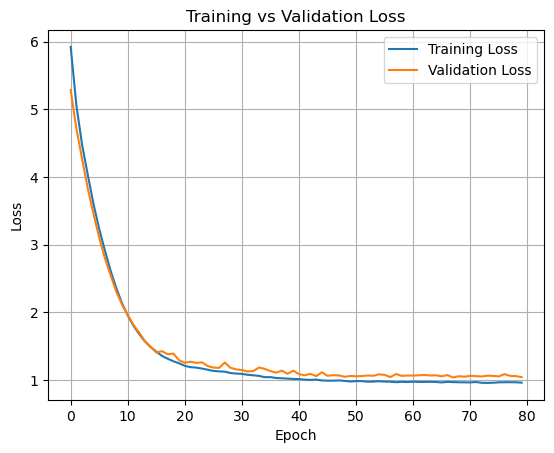

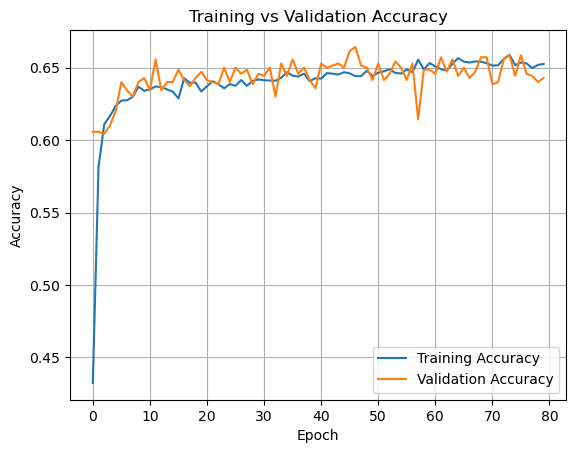

In [ ]:

model = models.Sequential()

# Create the hidden layer with sigmoid activations
model.add(layers.Dense(units=100, kernel_regularizer=regularizers.L1(0.001),
                     activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(rate=0.4))
model.add(layers.Dense(units=200, kernel_regularizer=regularizers.L1(0.001),
                     activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(units=200, kernel_regularizer=regularizers.L1(0.001),
                     activation='relu'))
model.add(layers.BatchNormalization())

model.add(layers.Dense(units=5, activation='softmax'))

# Compile the network with the appropriate loss function and keep track of accuracy
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, batch_size=100, epochs=80, validation_split=.1)

# See how the model scored
loss, accuracy  = model.evaluate(X_test, y_test)

print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

##### Creature a heat map 

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


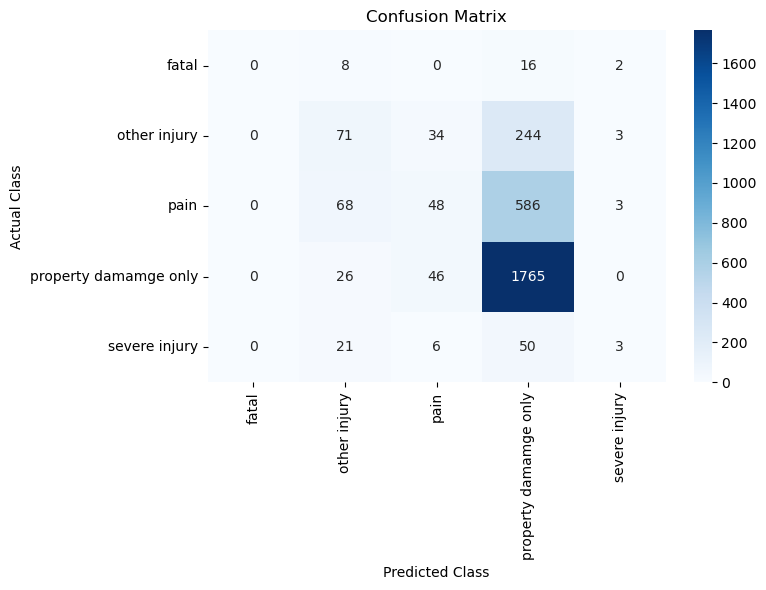

In [31]:

# Convert one-hot encoded y_test to class labels
y_true = tf.argmax(y_test, axis=1).numpy()

# Get predictions from the model and convert to class labels
y_pred_probs = model.predict(X_test)
y_pred = tf.argmax(y_pred_probs, axis=1).numpy()

# reassign class names
classes = ["fatal", "other injury", "pain", "property damamge only", "severe injury"]

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the heatmap
plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                 xticklabels=classes, yticklabels=classes)
ax.set_xlabel('Predicted Class')
ax.set_ylabel('Actual Class')
ax.set_title('Confusion Matrix')
plt.tight_layout()
plt.show()



# Conclusion

The model achieved a validation accuracy of approximately 60%. While the addition of regularization effectively reduced overfitting, increasing the model's complexity did not lead to improvements in validation performance. This suggests that the features used to predict collision severity may not have been sufficiently informative to accurately distinguish between all severity classes.

Additionally, the dataset exhibited class imbalance, with "Property Damage Only" being the most frequently occurring category. This imbalance is reflected in the model’s predictions, as this class was predicted with the highest accuracy compared to others.